In [2]:
# ! pip install seaborn

In [3]:
# !pip install transformers

In [4]:
# !pip install tensorflow
# ! pip install --upgrade pip

In [5]:
# !pip install tqdm

In [6]:
# !pip install nltk

In [7]:
# !pip install textblob

In [8]:
# !python -m textblob.download_corpora

In [9]:
pip install --upgrade tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 49.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0
Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from textblob import Word
from tensorflow.keras import backend as K

In [11]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# num_tpus_available = len(tf.config.experimental.list_physical_devices('TPU'))
# print("Num TPUs Available: ", num_tpus_available)
# assert num_tpus_available > 0

In [13]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  2


# Load Data

In [14]:
# Load data
train_data = pd.read_csv('/kaggle/input/amazon-comments/train_data.csv', low_memory=False)
test_data = pd.read_csv('/kaggle/input/amazon-comments/test_data.csv')
map_data = pd.read_csv('/kaggle/input/amazon-comments/title_brand.csv')

In [15]:
train_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [16]:
test_data.head()

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,NaN,True,2018-06-04,A20GGWE66JW9X2,B006Z394GM,{'Color:': ' FPS01-C'},Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...,1528070400
1,NaN,True,2018-02-18,ARYJWXHEYHG9M,B005BE058W,"{'Size:': ' 1000W', 'Style:': ' G2'}",Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR,1518912000
2,NaN,True,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,NaN,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular,1516406400
3,NaN,True,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,NaN,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!,1529884800
4,3.0,True,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,NaN,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy,1471392000


In [17]:
null_df = pd.concat([train_data.isna().sum() * 100 / len(train_data) , train_data.isna().sum()], axis=1)
null_df.columns=["percent", "num"]
null_df

,percent,num
overall,0.000000,0
vote,77.177499,647476
verified,0.000000,0
reviewTime,0.000000,0
reviewerID,0.000000,0
asin,0.000000,0
style,41.520173,348331
reviewerName,0.024078,202
reviewText,0.000000,0
summary,0.008940,75


In [18]:
test_data.isna().sum() * 100 / len(test_data) 

vote              75.335
verified           0.000
reviewTime         0.000
reviewerID         0.000
asin               0.000
style             42.480
reviewerName       0.020
reviewText         0.000
summary            0.010
unixReviewTime     0.000
dtype: float64

In [172]:
df_train = train_data.copy()
df_test = test_data.copy()

In [20]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Normalizing Case Folding - Uppercase to Lowercase
    text = text.lower()
    
#     # StopWords
#     sw = stopwords.words('english')
#     text = " ".join(x for x in text.split() if x not in sw)

#     # Remove Rare Words
#     temp_df = pd.Series(' '.join(text).split()).value_counts()
#     drops = temp_df[temp_df <= 1].index
#     text = " ".join(x for x in text.split() if x not in drops)
# #     # Lemmatize
# #     text = " ".join([Word(word).lemmatize() for word in text.split()])
#     text = " ".join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [21]:
def text_preprocessing(df, dependent_var):
#     lemmatizer = WordNetLemmatizer()
    dataframe = df.copy()
    for i in tqdm(range(3)):
        if i == 0:
            # Remove non-alphanumeric characters and extra whitespace
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
        if i == 1:
            # Convert multiple whitespace characters to a single space
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'\s+', ' ', x))
        if i == 2:
            # Normalizing Case Folding - Uppercase to Lowercase
            dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
#         if i == 3:
#             # StopWords
#             sw = stopwords.words('english')
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#         if i == 3:
#             # Remove Rare Words
#             temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
#             drops = temp_df[temp_df <= 1]
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
#         if i == 4:
#             # Lemmatize
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))

    return dataframe

In [173]:
df_train1 = text_preprocessing(df_train, "reviewText")
df_train1 = text_preprocessing(df_train, "summary")

100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


In [174]:
df_test1 = text_preprocessing(df_test, "reviewText")
df_test1 = text_preprocessing(df_test1, "summary")

100%|██████████| 3/3 [00:00<00:00, 13.11it/s]


In [180]:
df_train['reviewText'] = df_train['reviewText'].apply(text_cleaning)
df_train['summary'] = df_train['summary'].fillna('')
df_train['summary'] = df_train['summary'].apply(text_cleaning)

In [181]:
df_test['reviewText'] = df_test['reviewText'].apply(text_cleaning)
df_test['summary'] = df_test['summary'].fillna('')
df_test['summary'] = df_test['summary'].apply(text_cleaning)

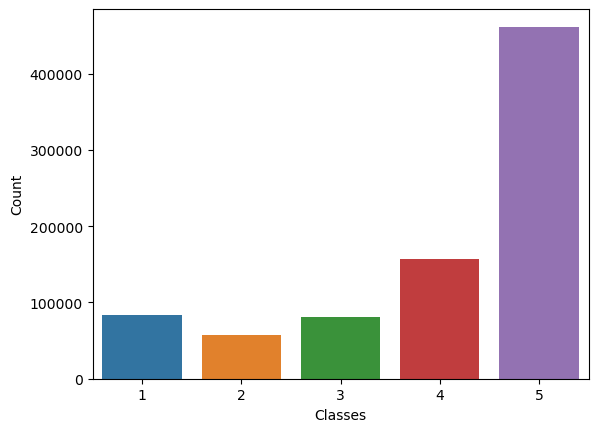

In [25]:
counts = df_train['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [176]:
# df_train["sentiment"] = df_train["overall"].apply(lambda score: "positive" if score >= 3 else "negative")
# df_train['sentiment'] = df_train['sentiment'].map({'positive':1, 'negative':0})

In [182]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [183]:
df_train['summary_lengths'] = df_train['summary'].apply(len)

In [184]:
df_train['review_lengths'].max()

28429

In [187]:
df_train['summary_lengths'].max()

352

In [188]:
df_train['overall'].value_counts() #/ len(df)

5    461485
4    156514
1     82950
3     81239
2     56756
Name: overall, dtype: int64

In [197]:
df_train[df_train['review_lengths'] < 600]['overall'].value_counts() #/ len(df)

5    339951
4    103228
1     59374
3     54787
2     38391
Name: overall, dtype: int64

## Drop reviewTexts where len(reviewText) > 600 and len(summary) < 200

In [209]:
df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 200)].index

Int64Index([     7,      8,     26,     28,     45,     53,     54,     55,
                56,     58,
            ...
            838908, 838911, 838912, 838914, 838920, 838923, 838929, 838930,
            838933, 838937],
           dtype='int64', length=242637)

In [210]:
drop_indexes = df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 200)].index

In [211]:
df_train = df_train.drop(drop_indexes)

In [33]:
# large_review_indexes = df_train[df_train['review_lengths'] > 600].index 

In [34]:
# df_train.loc[large_review_indexes, 'reviewText'] = df_train.loc[large_review_indexes, 'summary']

In [213]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [214]:
df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 200)]['overall'].value_counts() #/ len(df)

Series([], Name: overall, dtype: int64)

## Sampling

In [ ]:
counts = df_train['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [41]:
def sampling(df, num_target, each_class_size):
    # Identify the size of the smallest class
    min_class_size = min(each_class_size, df[num_target].value_counts().min())

    # Perform random sampling for each class to balance the sizes
    balanced_df = pd.concat([
        df[df[num_target] == sentiment].sample(min_class_size, replace=True)
        for sentiment in df[num_target].unique()
    ])

    # Shuffle the rows to randomize the order of samples
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    return balanced_df

In [215]:
df_train_balanced = sampling(df_train, 'overall', 4000)

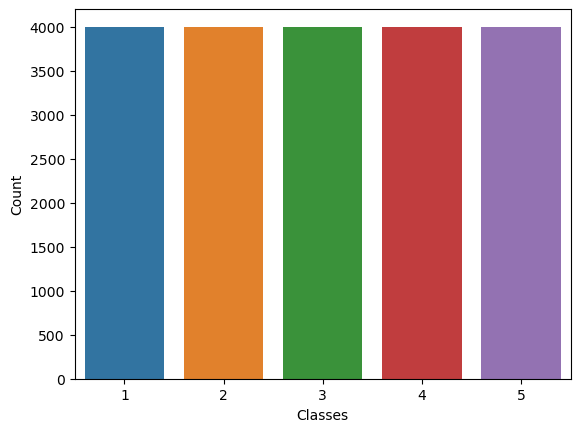

In [216]:
counts = df_train_balanced['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Model 1

## Split Train and Validation

In [44]:
# Training data
Reviews = df_train_balanced['reviewText']
labels = df_train_balanced['overall']
# Test data
test_reviews = df_test['reviewText']

In [45]:
train_reviews, validation_reviews, train_labels, validation_labels = train_test_split(Reviews, labels, test_size=0.3)

# BERT

tokenizer

In [46]:
tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer2 = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Apply tokenizer on Train, Validation and test

In [47]:
max_len= 128
# Tokenize and encode the sentences
train_encoded = tokenizer1.batch_encode_plus(train_reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
val_encoded = tokenizer1.batch_encode_plus(validation_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
test_encoded = tokenizer1.batch_encode_plus(test_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

Check the encoded dataset

In [49]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer1.decode(train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',train_encoded['attention_mask'][k])
print('\nLabels -->>',labels[k])


Training Comments -->> it says in the directions to keep the phone or whatever device youre using on your left side so it has better reception to the

Input Ids -->>
 tf.Tensor(
[  101  1045  4156  2023  2144  9574  2515  2025  2031  1037 11519  2655
 10851  5724  2800  1998  9832  2000  2031  2028 15933  2574  2174  1045
  2031  2000  2709  2009  2138  2096  2009  8534  4455  2009  2106  2025
  3499  2033  2000  4374  6904  2595  2130  2295  1045  5720  2000 18133
  2099  4087  2490  2002  2409  2149  2000  2224  1037  3975  3334  1998
  2008  2515  2025  2147  2007  2256  6522  2035  5740  2638  2061 13718
  1045  2018  2000  2709  2009  1998  2085  1045  2131  2000  4952  2000
  6970 22311  3468 12403  2213  4455  1045  2428  4299  2009  2018  2499
  2005  2149  2065  2017  2123  2102  2342  2000  4374  6904 20156  2009
  2052  2763  2022  1037  2204  4031   102     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)

Decoded Ids -

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(train_encoded),
#     train_labels
# ))

# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(val_encoded),
#     validation_labels
# ))

Build Classification Model

In [50]:
# Intialize the model
model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_macro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_micro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss = tf.keras.losses.CategoricalCrossentropy(
#     from_logits= True,
    name='categorical_crossentropy'
)
metric = ['accuracy', f1_micro]

In [60]:
# Compile the model with an appropriate optimizer, loss function, and metrics
model1.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

### Train the model

In [63]:
validation_labels

712      3
14611    4
18699    3
10503    3
15963    3
        ..
13475    5
3073     5
9921     3
9024     2
1808     5
Name: overall, Length: 6000, dtype: int64

In [75]:
# Assuming your labels are in the range [1, 2, 3, 4, 5]
train_labels -= 1
validation_labels -= 1

num_classes = 5

model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Use SparseCategoricalCrossentropy for integer-encoded labels
metric = ['accuracy', f1_micro]
model1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history1 = model1.fit(
    [train_encoded['input_ids'], train_encoded['token_type_ids'], train_encoded['attention_mask']], 
    train_labels,
    validation_data=(
        [val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']], 
        validation_labels
    ),
    batch_size=32,
    epochs=3
)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
 11/438 [..............................] - ETA: 4:57 - loss: nan - accuracy: 0.0000e+00 - f1_micro: nan


KeyboardInterrupt



In [ ]:
history1 = model1.fit([train_encoded['input_ids'], train_encoded['token_type_ids'], 
                     train_encoded['attention_mask']], train_labels,
                    validation_data=(
                        [val_encoded['input_ids'], val_encoded['token_type_ids'], 
                         val_encoded['attention_mask']], validation_labels),
                    batch_size=32,
                    epochs=3
)

In [73]:
# Assuming your labels are in the range [1, 2, 3, 4, 5]
train_labels -= 1
validation_labels -= 1

num_classes = 5

model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Use SparseCategoricalCrossentropy for integer-encoded labels
metric = ['accuracy']
model1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history1 = model1.fit(
    [train_encoded['input_ids'], train_encoded['token_type_ids'], train_encoded['attention_mask']], 
    train_labels,
    validation_data=(
        [val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']], 
        validation_labels
    ),
    batch_size=32,
    epochs=30,
    callbacks=[early_stopping]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
  9/438 [..............................] - ETA: 5:05 - loss: nan - accuracy: 0.0000e+00 - f1_micro: nan

KeyboardInterrupt: 

In [ ]:
# history2 = model2.fit(train_dataset.shuffle(100).batch(16),
#           epochs=3,
#           batch_size=16,
#           validation_data=val_dataset.shuffle(100).batch(16))

## Evaluate

In [ ]:
bert_model = model1

In [ ]:
pred_val = bert_model.predict(
    [val_encoded['input_ids'], 
     val_encoded['token_type_ids'], 
     val_encoded['attention_mask']])

# pred_val = bert_model.predict(val_dataset)

# pred is of type TFSequenceClassifierOutput
logits = pred_val.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_val_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_val_labels = pred_val_labels.numpy()

label = {1: 'positive', 0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_val_labels = [label[i] for i in pred_val_labels]
Actual = [label[i] for i in validation_labels]

print('Predicted Label :', pred_val_labels[:10])
print('Actual Label :', Actual[:10])


In [ ]:

print("Classification Report: \n", classification_report(Actual, pred_val_labels))

In [ ]:
# path = '/kaggle/working'
# # Save tokenizer
# tokenizer.save_pretrained(path +'/Tokenizer')

# # Save model
# model1.save_pretrained(path +'/Model')


In [ ]:
# # Load tokenizer
# bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# # Load model
# bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


## Model 3

In [218]:
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [219]:
df_train_val_balanced = df_train_balanced.copy()

In [220]:
df_train_val_balanced = df_train_balanced[['reviewText', 'overall']]
df_train_val_balanced.columns = ['Input', 'Sentiment']
df_train_val_balanced['Sentiment'] = df_train_val_balanced['Sentiment'] - 1
df_train_val_balanced.head()

/tmp/ipykernel_32/1619333711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_val_balanced['Sentiment'] = df_train_val_balanced['Sentiment'] - 1


,Input,Sentiment
0,this is one of the largest bluetooth speakers ...,3
1,a little fussy because of the volume control g...,2
2,they look good they feel good they just dont w...,0
3,this is probably one of the best purchases ive...,4
4,good item for the price i cannot use the new i...,3


In [221]:
X_train, X_validation, y_train, y_validation = train_test_split(df_train_val_balanced[['Input']], df_train_val_balanced['Sentiment'], random_state=42)

In [222]:
df_test2 = df_test[['reviewText']]
df_test2.columns = ['Input']
df_test2.head()

,Input
0,the name and description of this device are mi...
1,one of the molex connectors on the power suppl...
2,remote constantly disconnects roku player free...
3,i purchased this year protection plan for a se...
4,i bought one of these and have regretted it ev...


In [223]:
y_train_cat = to_categorical(y_train)
y_validation_cat = to_categorical(y_validation)

In [224]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [236]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
max_len = 100
x_train = tokenizer(
    text=X_train.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_validation = tokenizer(
    text=X_validation.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=df_test2.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [240]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(5,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
model.summary()

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=2,
                                               mode='max',
                                               restore_best_weights=True)

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_cat,
    validation_data = (
    {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']},
        y_validation_cat
    ),
  epochs=10,
    batch_size=32
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 414s 774ms/step - loss: 1.1835 - balanced_accuracy: 0.4735 - val_loss: 1.0511 - val_balanced_accuracy: 0.5428
Epoch 2/10
469/469 [==============================] - 353s 752ms/step - loss: 0.9050 - balanced_accuracy: 0.6098 - val_loss: 1.0415 - val_balanced_accuracy: 0.5672
Epoch 3/10
469/469 [==============================] - 352s 750ms/step - loss: 0.7056 - balanced_accuracy: 0.7065 - val_loss: 1.0597 - val_balanced_accuracy: 0.5768
Epoch 4/10
469/469 [==============================] - 352s 750ms/step - loss: 0.5038 - balanced_accuracy: 0.8000 - val_loss: 1.2975 - val_balanced_accuracy: 0.5600
Epoch 5/10
469/469 [==============================] - 351s 748ms/step - loss: 0.3554 - balanced_accuracy: 0.8628 - val_loss: 1.4085 - val_balanced_accuracy: 0.5474
Epoch 6/10
469/469 [==============================] - 351s 749ms/step - loss: 0.2756 - balanced_accuracy: 0.8950 - val_loss: 1.5772 - val_balanced_accuracy: 0.5674
Epoch 7/10
469/469 [=======

In [243]:
predicted_val = model.predict({'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']})
y_val_predicted = np.argmax(predicted_val, axis=1)
y_true = y_validation
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

157/157 [==============================] - 35s 223ms/step
F1_micro: 0.5784


In [ ]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(128, activation='relu')(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(5,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
model.summary()

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy() #from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=3,
                                               mode='max',
                                               restore_best_weights=True)

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_cat,
    validation_data = (
    {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']},
        y_validation_cat
    ),
  epochs=10,
    batch_size=32
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_9 (Global  (None, 768)         0           ['tf_bert_model_5[6][0]']  

In [ ]:
predicted_val = model.predict({'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']})
y_val_predicted = np.argmax(predicted_val, axis=1)
y_true = y_validation
print(f'F1_micro: {f1_score(y_validation, y_val_predicted, average='micro')}')

In [ ]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(128, activation='relu')(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(5,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
model.summary()

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=3,
                                               mode='max',
                                               restore_best_weights=True)

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_cat,
    validation_data = (
    {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']},
        y_validation_cat
    ),
  epochs=10,
    batch_size=32
)

In [ ]:
predicted_val = model.predict({'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']})
y_val_predicted = np.argmax(predicted_val, axis=1)
y_true = y_validation
print(f'F1_micro: {f1_score(y_validation, y_val_predicted, average='micro')}')

In [ ]:

# Assuming your labels are in the range [1, 2, 3, 4, 5]
train_labels -= 1
validation_labels -= 1

num_classes = 5

model3 = TFBertModel.from_pretrained('bert-base-cased', num_labels=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # Use SparseCategoricalCrossentropy for integer-encoded labels
metric = ['accuracy']
model3.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               min_delta=0,
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)

history1 = model1.fit(
    [train_encoded['input_ids'], train_encoded['token_type_ids'], train_encoded['attention_mask']], 
    train_labels,
    validation_data=(
        [val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']], 
        validation_labels
    ),
    batch_size=32,
    epochs=30,
    callbacks=[early_stopping]
)

# Test

In [ ]:
# pred_test = bert_model.predict(test_encoded)

pred_test = bert_model.predict(
    [test_encoded['input_ids'], 
     test_encoded['token_type_ids'], 
     test_encoded['attention_mask']])

# pred_val = bert_model.predict(val_dataset)

# pred is of type TFSequenceClassifierOutput
logits = pred_test.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_test_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_test_labels = pred_test_labels.numpy()

label = {1: 'positive', 0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_test_labels = [label[i] for i in pred_test_labels]

print('Predicted Label :', pred_val_labels[:10])


In [ ]:
len(pred_test_labels)